#MISI SCORING MODEL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# List of CSV file names
datasets = {
    "corruption_index": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/Corruption_index_Cleaned.csv",
    "public_sector_debt": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/Filtered_Public_Sector_Debt.csv",
    "fdi": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/Foreign_direct_investment_Cleaned in USD.csv",  # Fixed filename issue
    "gdp": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/National_GDP_in_USD_Cleaned.csv",
    "political_stability": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/Population_growth_rate_Cleaned.csv",
    "population_growth": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/Unemployment_rate_ Cleaned.csv",
    "unemployment_rate": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/birth_rate_cleaned.csv",  # Fixed filename issue
    "birth_rate": "/content/drive/MyDrive/Scoring Model Project/Cleaned-Data-V2/political_stability_cleaned.csv"
}

# Load CSV files into a dictionary of DataFrames
dataframes = {}
for key, path in datasets.items():
    try:
        dataframes[key] = pd.read_csv(path)
        # Force 'Country' and 'Year' columns to string type
        if 'Country' in dataframes[key].columns:
            dataframes[key]['Country'] = dataframes[key]['Country'].astype(str)
        if 'Year' in dataframes[key].columns:
            dataframes[key]['Year'] = dataframes[key]['Year'].astype(str)
    except Exception as e:
        print(f"🚨 Error loading {key}: {e}")

# Convert wide format to long format
for key, df in dataframes.items():
    if "Country" in df.columns:
        df_melted = df.melt(id_vars=["Country"], var_name="Year", value_name=key)
        df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors='coerce')  # Convert Year column safely
        df_melted[key] = pd.to_numeric(df_melted[key], errors='coerce')  # Convert data to numeric safely
        dataframes[key] = df_melted.dropna(subset=["Country"])  # Drop NaN Country values
    else:
        print(f"🚨 Missing 'Country' column in {key}")

# Merge datasets on Country and Year
df_merged = None
for key, df in dataframes.items():
    # Ensure Country & Year are valid and of the same type before merging
    df.dropna(subset=["Country", "Year"], inplace=True)
    df['Country'] = df['Country'].astype(str)
    df['Year'] = df['Year'].astype(str)

    if df_merged is None:
        df_merged = df
    else:
        # Use inner join to ensure only common countries and years are included
        df_merged = pd.merge(df_merged, df, on=["Country", "Year"], how="inner")

# Check for missing values
if df_merged is None or df_merged.empty:
    print("🚨 No valid data available for merging. Check dataset structure.")
    exit()

missing_values = df_merged.isnull().sum()
print("🔍 Missing Values Before Imputation:\n", missing_values[missing_values > 0])

# Fill missing values using median imputation
imputer = SimpleImputer(strategy="median")
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
df_merged[numeric_cols] = imputer.fit_transform(df_merged[numeric_cols])

# Verify no missing values remain
if df_merged.isnull().sum().sum() == 0:
    print("✅ Missing values successfully imputed.")
else:
    print("⚠️ Some missing values remain. Check dataset integrity.")

# Ensure all numeric columns are properly converted
df_merged[numeric_cols] = df_merged[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Normalize numerical data
scaler = StandardScaler()
df_merged[numeric_cols] = scaler.fit_transform(df_merged[numeric_cols])

# Compute Investment Stability Index (Weighted Sum Model)
df_merged["investment_stability_index"] = (
    df_merged["corruption_index"] * 0.15 +
    df_merged["political_stability"] * 0.15 +
    df_merged["fdi"] * 0.2 +
    df_merged["gdp"] * 0.15 +
    df_merged["unemployment_rate"] * -0.1 +
    df_merged["population_growth"] * 0.1 +
    df_merged["birth_rate"] * -0.15 +
    df_merged["public_sector_debt"] * -0.1
)

# Ensure no NaN values in target variable
if df_merged["investment_stability_index"].isnull().sum() > 0:
    print("🚨 Target variable contains NaN values. Check dataset.")
    exit()

# Prepare Data for Model
X = df_merged.drop(columns=["Country", "Year", "investment_stability_index"], errors='ignore')
y = df_merged.get("investment_stability_index", None)

# Train the model if target variable exists
if y is not None and not y.isnull().any():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if len(X_train) == 0 or len(y_train) == 0:
        print("🚨 Not enough data to train the model. Check dataset.")
        exit()

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"📊 Model Mean Absolute Error: {mae:.4f}")

    # ✅ Fixing Country Ranking Issue
    ranking_df = df_merged[["Country", "Year", "investment_stability_index"]].drop_duplicates()

    # 🔹 Take the latest year for each country
    ranking_df = ranking_df.sort_values(by=["Country", "Year"], ascending=[True, False])
    ranking_df = ranking_df.drop_duplicates(subset=["Country"], keep="first")

    # 🔹 Sort by investment stability index in descending order
    ranking_df = ranking_df.sort_values(by="investment_stability_index", ascending=False)

    # Display Top 10 Countries
    print("\n🏆 Top 10 Investment-Friendly Countries:")
    print(ranking_df[["Country", "investment_stability_index"]].head(11))

else:
    print("🚨 No valid target variable found. Model training skipped.")





🔍 Missing Values Before Imputation:
 Series([], dtype: int64)
✅ Missing values successfully imputed.
📊 Model Mean Absolute Error: 0.0685

🏆 Top 10 Investment-Friendly Countries:
           Country  investment_stability_index
517  United States                    1.926988
484         Canada                    0.607787
481      Australia                    0.383318
512          Spain                    0.341630
490        Estonia                    0.254483
507         Norway                    0.197853
503     Luxembourg                    0.192767
513         Sweden                    0.147670
489        Denmark                    0.136362
496        Iceland                    0.109886
491        Finland                    0.104992


#Correlation Map

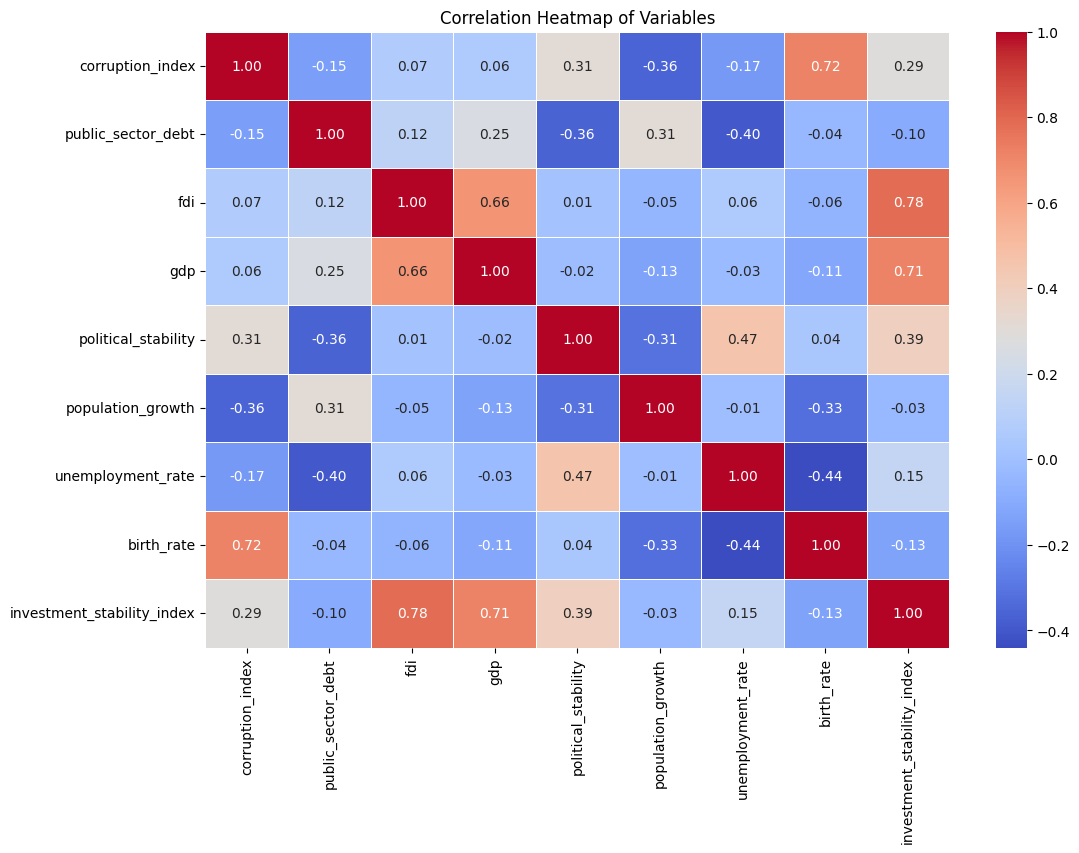

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
# Exclude non-numeric columns, specifically 'Country'
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
corr_matrix = df_merged[numeric_cols].corr()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.show()

#Distribution of Investment

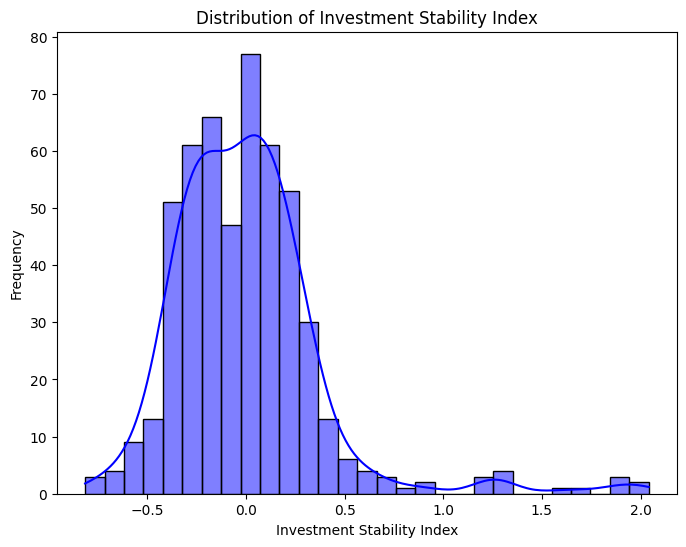

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_merged['investment_stability_index'], kde=True, color="blue")
plt.title('Distribution of Investment Stability Index')
plt.xlabel('Investment Stability Index')
plt.ylabel('Frequency')
plt.show()

#Bar Chart of Investment Friendly Countries

<ipython-input-17-2c4c99bd4b7e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='investment_stability_index', y='Country', data=top_10, palette="viridis")


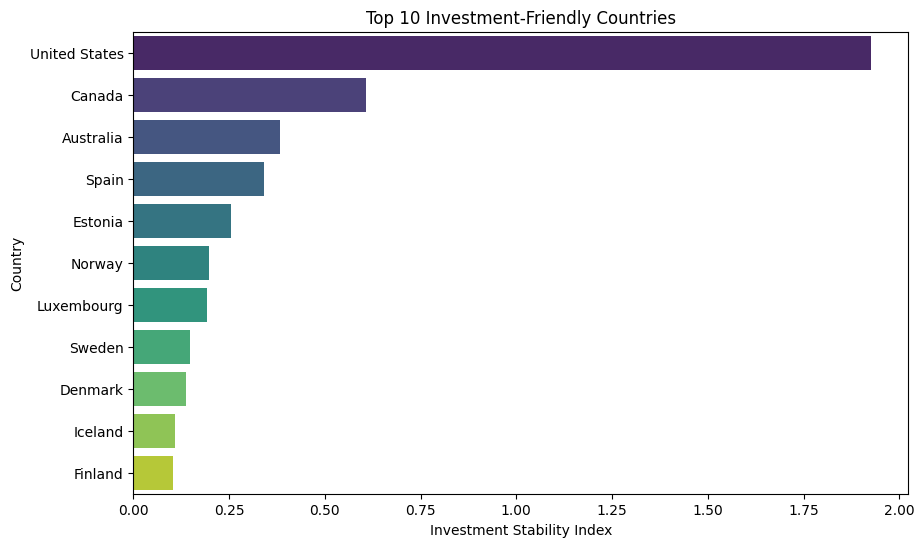

In [ ]:
# Plotting the top 10 countries
top_10 = ranking_df.head(11)
plt.figure(figsize=(10, 6))
sns.barplot(x='investment_stability_index', y='Country', data=top_10, palette="viridis")
plt.title('Top 10 Investment-Friendly Countries')
plt.xlabel('Investment Stability Index')
plt.ylabel('Country')
plt.show()

#Feauture Importance Visualizations

<ipython-input-18-2fefff10e23a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="Blues_d")


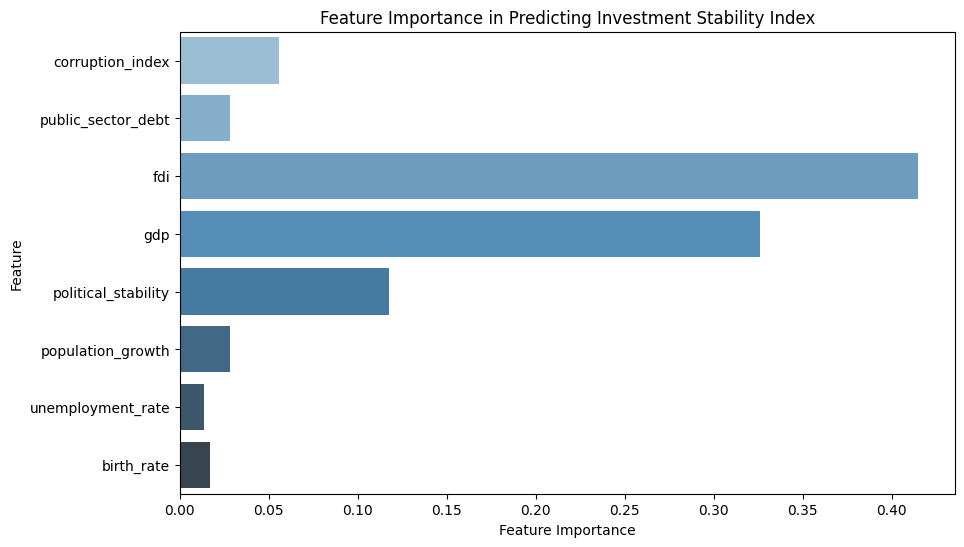

In [ ]:
# Plot feature importance
feature_importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, palette="Blues_d")
plt.title('Feature Importance in Predicting Investment Stability Index')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

#Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE and R^2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 R^2 Score: {r2:.4f}")

📊 RMSE: 0.0967
📊 R^2 Score: 0.9056


#Outlier Detection

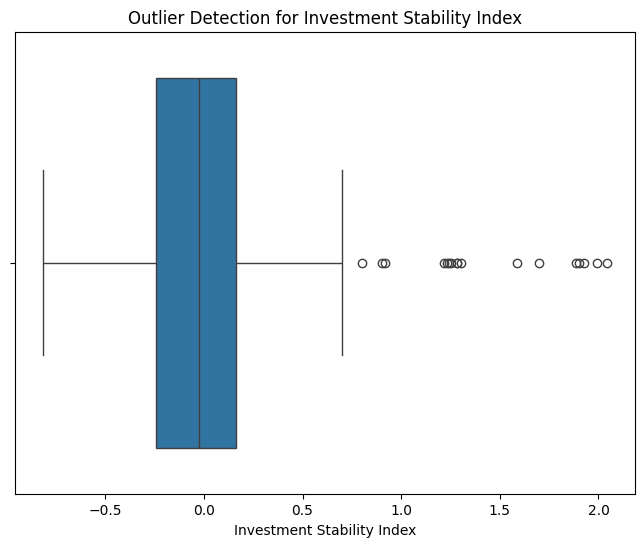

In [ ]:
# Boxplot to detect outliers for Investment Stability Index
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_merged['investment_stability_index'])
plt.title('Outlier Detection for Investment Stability Index')
plt.xlabel('Investment Stability Index')
plt.show()

#Cluster Analysis -- K-Means or Hierarchical Clustering

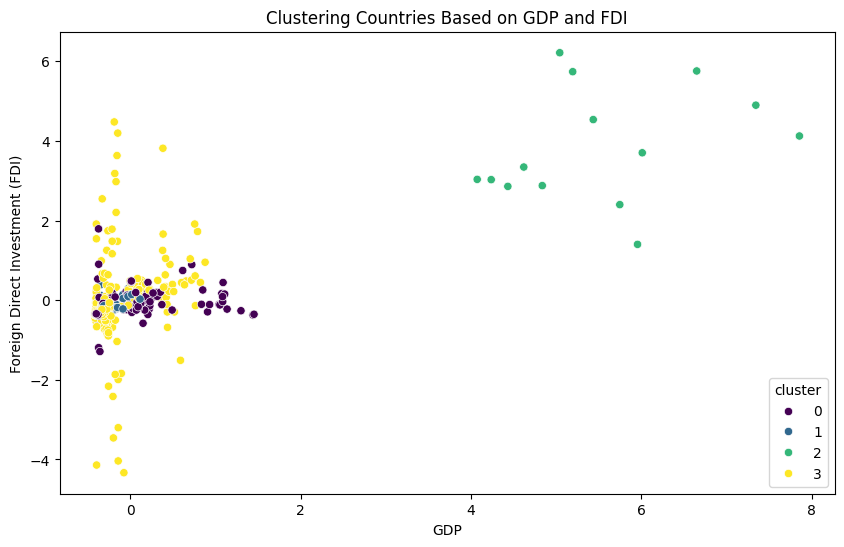

In [ ]:
from sklearn.cluster import KMeans

# Select relevant features
X_cluster = df_merged[["corruption_index", "political_stability", "fdi", "gdp", "unemployment_rate", "population_growth"]]

# Normalize the data for clustering
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_merged['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Plotting clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x="gdp", y="fdi", hue="cluster", palette="viridis")
plt.title('Clustering Countries Based on GDP and FDI')
plt.xlabel('GDP')
plt.ylabel('Foreign Direct Investment (FDI)')
plt.show()